 COMPARACIÓN DEL Nº DE COPIA NORMALIZADO (NCN)
=====

Frente a la pregunta ¿dónde hay mayor nº de copias de ARG/MGE? el poder responder ha sido siempre controvertido, puesto que el hecho de que haya infinidad de 0s dificulta muchísimo el tomar todos los datos en conjunto a la par que la contra, el centrarse sólo en los genes que han amplificado, dificulta mucho el poder responder a la pregunta y quita muchísimas réplicas, tanto que empieza a haber problemas de poder estadístico.

Sin embargo, creo que la solución pasa por asumir esas dos circunstancias y hacerlas parte de nuestra respuesta: ¿dónde hay mayor nº de copias de ARG/MGE? Depende: a nivel general, en los plásticos por su mayor diversidad, pero a nivel de genes/familias compartidas, la respuesta depende del ambiente, aunque hay casos en los que nos falta poder estadístico para poder responder con seguridad

Dicho eso, al meollo.

Se me ocurre responder de dos maneras a la pregunta.

- Ver cuáles son los ARG comunes, computar la suma de NCN para ellos en cada muestra, dividirlo por el nº de secuencias comunes para ese caso y comparar
- Por si hiciera falta, también se puede respaldar con la misma pregunta pero usando todas las secuencias. Eso respondería en general.

Ojo, voy a separar desde el principio ARGs y MGEs. No me interesa comparar entre ellos en ningún caso y tenerlos juntos supone mezclar dos datasets que pueden meter mucho ruido sin causa justificada.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import scikit_posthocs as sp
import matplotlib
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Current wd: the script directory
os.chdir("../data/clean_data") #data directory
data_dir = os.getcwd()
os.chdir("../../results/NCN_res") # general results dir for these analysis
os.chdir("all") # the subdirectory for when all data is considered
all_dir = os.getcwd()
print(os.getcwd())

/home/pak/Desktop/ARG-L/resistome/results/NCN_res/all


In [3]:
os.chdir(data_dir)
all_data = pd.read_csv("ab_data_all_fixed.csv", index_col = 0)
os.chdir(all_dir)
all_data.fillna(0, inplace = True)
all_data = all_data[(all_data["antib"] != "16S")]
all_data = all_data[["Assay", "antib", "sample", "place", "type_f", "type_g", "or_seq", "rel_ab"]] #place viene a ser la estrella del show
all_data = all_data.loc[~all_data["place"].isin([0])]
all_data.loc[all_data["sample"] == 13, "rel_ab"] = all_data.loc[all_data["sample"] == 13]["rel_ab"] / 3
all_data.loc[all_data["sample"] == 14, "rel_ab"] = all_data.loc[all_data["sample"] == 14]["rel_ab"] / 3
all_data = all_data[(all_data.Assay != "aadA7") & (all_data.sample != 5)] #esto también es tremendamente importante
all_data.head()

,Assay,antib,sample,place,type_f,type_g,or_seq,rel_ab
0,aacC2,Aminoglycoside,25.0,ardley,PUR,plastic,arg,0.000222
1,aacA/aphD,Aminoglycoside,25.0,ardley,PUR,plastic,arg,0.000046
2,aac(6')-II,Aminoglycoside,25.0,ardley,PUR,plastic,arg,0.006918
3,aphA3,Aminoglycoside,25.0,ardley,PUR,plastic,arg,0.000000
4,sat4,Aminoglycoside,25.0,ardley,PUR,plastic,arg,0.000000


There's a last fix that needs to be made to the dataset: group both lakes as a general "lake" variable. I won't be able to do statistics on Ionosférico data due to the low number of replicates, so separating by sampling place is not an option. However, separating by sampling ambient (lacustrine vs inland) is. Also, I won't be dropping the original place column, as that variable is still needed to filter for common amps

In [4]:
all_data.loc[all_data["place"] == "ardley", "ambient"] = "Ardley"
all_data.loc[all_data["place"] != "ardley", "ambient"] = "Lakes"
all_data.tail()

,Assay,antib,sample,place,type_f,type_g,or_seq,rel_ab,ambient
10309,dfrAB4,Trimethoprim,14.0,ion,water,control,arg,0.0,Lakes
10310,dfrC,Trimethoprim,14.0,ion,water,control,arg,0.0,Lakes
10311,dfrG,Trimethoprim,14.0,ion,water,control,arg,0.0,Lakes
10312,dfrK,Trimethoprim,14.0,ion,water,control,arg,0.0,Lakes
10313,dfrBmulti,Trimethoprim,14.0,ion,water,control,arg,0.0,Lakes


And a couple more fixes, seen down the line

In [5]:
# Fix names for figure purposes
all_data.loc[all_data["type_g"] == "plastic", "type_g"] = "Plastic"
all_data.loc[all_data["type_g"] == "control", "type_g"] = "Surrounding \n environment"
all_data.loc[all_data["type_f"] == "water", "type_f"] = "Water"
all_data.loc[all_data["type_f"] == "soil", "type_f"] = "Soil"
# Fix a misclassification
all_data.loc[all_data["antib"] == "Phenicol", "antib"] = "Amphenicol"

# Fix a bunch of badly assigned resistances 
all_data.loc[all_data["antib"] == "Other", "or_seq"] = "arg"
all_data.loc[all_data["Assay"] == "dfrA1", "antib"] = "Trimethoprim"
all_data.loc[all_data["Assay"] == "dfrA12", "antib"] = "Trimethoprim"
all_data.loc[all_data["Assay"] == "dfrA1", "or_seq"] = "arg"
all_data.loc[all_data["Assay"] == "dfrA12", "or_seq"] = "arg"

all_data

,Assay,antib,sample,place,type_f,type_g,or_seq,rel_ab,ambient
0,aacC2,Aminoglycoside,25.0,ardley,PUR,Plastic,arg,0.000222,Ardley
1,aacA/aphD,Aminoglycoside,25.0,ardley,PUR,Plastic,arg,0.000046,Ardley
2,aac(6')-II,Aminoglycoside,25.0,ardley,PUR,Plastic,arg,0.006918,Ardley
3,aphA3,Aminoglycoside,25.0,ardley,PUR,Plastic,arg,0.000000,Ardley
4,sat4,Aminoglycoside,25.0,ardley,PUR,Plastic,arg,0.000000,Ardley
...,...,...,...,...,...,...,...,...,...
10309,dfrAB4,Trimethoprim,14.0,ion,Water,Surrounding \n environment,arg,0.000000,Lakes
10310,dfrC,Trimethoprim,14.0,ion,Water,Surrounding \n environment,arg,0.000000,Lakes
10311,dfrG,Trimethoprim,14.0,ion,Water,Surrounding \n environment,arg,0.000000,Lakes
10312,dfrK,Trimethoprim,14.0,ion,Water,Surrounding \n environment,arg,0.000000,Lakes


In [6]:
def statistic_mean(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

### COMPARATIVA DEL Nº DE COPIA DIFERENCIANDO POR PUNTO DE MUESTREO

In [7]:
all_data["hacky"] = all_data["ambient"] + "-" + all_data["type_f"] 
sp_grouped = all_data.groupby(["sample", "or_seq", "hacky"]) #agrupa los datos según tipología. LO importante, también por nº de muestra
summed_samples = sp_grouped["rel_ab"].sum() # y calcula la suma del nº de copias de todos los integrantes
summed_samples = summed_samples.reset_index() #aquí paso a df para facilitar el resto de pasos
summed_samples["n_log2"] = np.log2(summed_samples["rel_ab"])
summed_samples.loc[summed_samples["sample"] == 21]

,sample,or_seq,hacky,rel_ab,n_log2
40,21.0,arg,Ardley-Soil,1.986300,0.990083
41,21.0,mge,Ardley-Soil,1.510478,0.595005


In [8]:
sp_grouped = all_data.groupby(["sample", "or_seq", "ambient", "type_g", "type_f"]) #agrupa los datos según tipología. LO importante, también por nº de muestra
summed_samples = sp_grouped["rel_ab"].sum() # y calcula la suma del nº de copias de todos los integrantes
summed_samples = summed_samples.reset_index() #aquí paso a df para facilitar el resto de pasos
summed_samples["n_log2"] = np.log2(summed_samples["rel_ab"])
summed_samples.loc[summed_samples["sample"] == 21]

,sample,or_seq,ambient,type_g,type_f,rel_ab,n_log2
40,21.0,arg,Ardley,Surrounding \n environment,Soil,1.986300,0.990083
41,21.0,mge,Ardley,Surrounding \n environment,Soil,1.510478,0.595005


#### ARG

In [9]:
for grouping in ["type_g", "type_f"]:
    print("######## ", grouping.upper(), " ########")
    for ambient in summed_samples["ambient"].unique():
        print("Working on ", ambient.upper())
        ambient_samples = summed_samples.loc[summed_samples["ambient"] == ambient]
        var_lst = [group["rel_ab"] for name, group in ambient_samples.loc[ambient_samples["or_seq"] == "arg"].groupby([grouping])] #contains every group
        nam_lst = [name for name, group in ambient_samples.loc[ambient_samples["or_seq"] == "arg"].groupby([grouping])] #contains the name of everygroup, SAME ORDER
        print("Regular values: ", stats.levene(*var_lst))
        var_lst_ln = [group["n_log2"] for name, group in ambient_samples.loc[ambient_samples["or_seq"] == "arg"].groupby([grouping])]
        print("Log2: ", stats.levene(*var_lst_ln))
        fname = ambient.upper() + "-" + grouping.upper() +  "-arg_group_statistics.txt"
        with open(fname, "w") as file:
            print("Regular_values: ", stats.levene(*var_lst), file = file)
            print("Regular_kruskal: ", stats.kruskal(*var_lst), file = file)
            print("Log2_values: ", stats.levene(*var_lst_ln), file = file)
            print("Log2_kruskal: ", stats.kruskal(*var_lst_ln), file = file)
        print(stats.kruskal(*var_lst))
        post_lolo = sp.posthoc_conover(var_lst, p_adjust = "fdr_bh")

        # me interesa que los resultados del posthoc sean comprensibles sin tener que sustituir cada valor numérico de los ejes por su 
        # correspondiente nombre a mano. Para ello, puedo aprovechar la lista de nombres nam_lst y generar una lista de nº ordenados que
        # contengan todos los nºs del eje. O lo que es lo mismo, el index y las columnas
        post_lolo.rename(columns = {original_num:new_name for (original_num, new_name) in zip(post_lolo.columns, nam_lst)},
                         index = {original_num:new_name for (original_num, new_name) in zip(post_lolo.index, nam_lst)},
                         inplace = True)

        # Y ahora ver solo lo interesante
        #post_lolo = post_lolo[post_lolo < 0.05]
        fname = ambient.upper() + "-" + grouping.upper() +  "-all_arg_comparisions.csv"
        post_lolo.to_csv(fname)
        print(post_lolo)

########  TYPE_G  ########
Working on  LAKES
Regular values:  LeveneResult(statistic=1.815431146457081, pvalue=0.19663033596846133)
Log2:  LeveneResult(statistic=3.2224895881691813, pvalue=0.0915443580841491)
KruskalResult(statistic=10.231578947368419, pvalue=0.0013805643129800346)
                               (Plastic,)  (Surrounding \n environment,)
(Plastic,)                       1.000000                       0.000154
(Surrounding \n environment,)    0.000154                       1.000000
Working on  ARDLEY
Regular values:  LeveneResult(statistic=0.4085378741798708, pvalue=0.5430539620566902)
Log2:  LeveneResult(statistic=3.5087888034103734, pvalue=0.1031952731569077)
KruskalResult(statistic=5.399999999999999, pvalue=0.020136751550346346)
                               (Plastic,)  (Surrounding \n environment,)
(Plastic,)                       1.000000                       0.006603
(Surrounding \n environment,)    0.006603                       1.000000
########  TYPE_F  ######

#### MGE

In [10]:
for grouping in ["type_g", "type_f"]:
    print("######## ", grouping.upper(), " ########")
    for ambient in summed_samples["ambient"].unique():
        print("Working on ", ambient.upper())
        ambient_samples = summed_samples.loc[summed_samples["ambient"] == ambient]
        var_lst = [group["rel_ab"] for name, group in ambient_samples.loc[ambient_samples["or_seq"] == "mge"].groupby([grouping])] #contains every group
        nam_lst = [name for name, group in ambient_samples.loc[ambient_samples["or_seq"] == "mge"].groupby([grouping])] #contains the name of everygroup, SAME ORDER
        print("Regular values: ", stats.levene(*var_lst))
        var_lst_ln = [group["n_log2"] for name, group in ambient_samples.loc[ambient_samples["or_seq"] == "mge"].groupby([grouping])]
        print("Log2: ", stats.levene(*var_lst_ln))
        fname = ambient.upper() + "-" + grouping.upper() +  "-mge_group_statistics.txt"
        with open(fname, "w") as file:
            print("Regular_values: ", stats.levene(*var_lst), file = file)
            print("Regular_kruskal: ", stats.kruskal(*var_lst), file = file)
            print("Log2_values: ", stats.levene(*var_lst_ln), file = file)
            print("Log2_kruskal: ", stats.kruskal(*var_lst_ln), file = file)
        print(stats.kruskal(*var_lst))
        post_lolo = sp.posthoc_conover(var_lst, p_adjust = "fdr_bh")
        post_lolo.rename(columns = {original_num:new_name for (original_num, new_name) in zip(post_lolo.columns, nam_lst)},
                         index = {original_num:new_name for (original_num, new_name) in zip(post_lolo.index, nam_lst)},
                         inplace = True)

        # Y ahora ver solo lo interesante
        #post_lolo = post_lolo[post_lolo < 0.05]
        fname = ambient.upper() + "-" + grouping.upper() +  "-all_mge_comparisions.csv"
        post_lolo.to_csv(fname)
        print(post_lolo)

########  TYPE_G  ########
Working on  LAKES
Regular values:  LeveneResult(statistic=0.1692289144716048, pvalue=0.6862556352723349)
Log2:  LeveneResult(statistic=1.3274398004826786, pvalue=0.2661860459460131)
KruskalResult(statistic=0.03157894736842337, pvalue=0.8589549227374772)
                               (Plastic,)  (Surrounding \n environment,)
(Plastic,)                       1.000000                       0.865162
(Surrounding \n environment,)    0.865162                       1.000000
Working on  ARDLEY
Regular values:  LeveneResult(statistic=2.586953523757021, pvalue=0.15178275259159912)
Log2:  LeveneResult(statistic=1.8758916833516772, pvalue=0.21311857998586642)
KruskalResult(statistic=5.399999999999999, pvalue=0.020136751550346346)
                               (Plastic,)  (Surrounding \n environment,)
(Plastic,)                       1.000000                       0.006603
(Surrounding \n environment,)    0.006603                       1.000000
########  TYPE_F  #######

#### graphs

In [11]:
summed_samples = all_data.groupby(["sample", "or_seq", "ambient", "type_g", "type_f"])["rel_ab"].sum().reset_index() #agrupa los datos según tipología. LO importante, también por nº de muestra
summed_samples["hacky"] = summed_samples["ambient"] + " " + summed_samples["type_f"]
summed_samples.sort_values(by = "hacky", inplace = True)
summed_samples["n_log2"] = np.log2(summed_samples["rel_ab"] + 1)
arg_general_sums = summed_samples.loc[summed_samples["or_seq"] == "arg"]
mge_general_sums = summed_samples.loc[summed_samples["or_seq"] == "mge"]

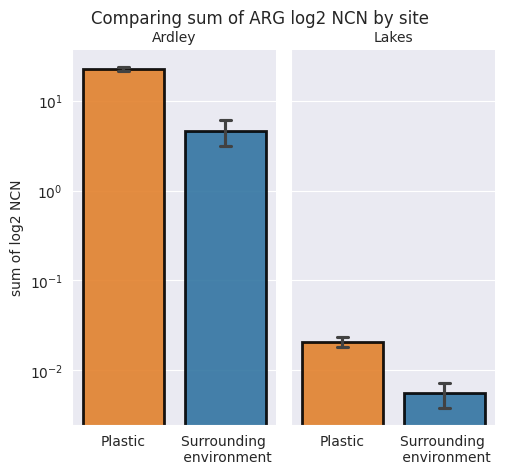

In [12]:
with sns.axes_style("darkgrid"):
    #sns.color_palette("husl", 8)
    cat = sns.catplot(data = arg_general_sums, kind = "bar",
                      x="type_g", y="rel_ab", col = "ambient",
                      alpha = 0.9, hue_order = ["Surrounding \n environment", "Plastic"],
                      height=5, aspect=0.5,
                      errorbar = "se", capsize = 0.1, ecolor = "black", hue = "type_g",
                      fill = True,  edgecolor = "black", linewidth = 2 
                    )
    cat.fig.subplots_adjust(top=0.9)
    cat.fig.suptitle('Comparing sum of ARG log2 NCN by site')
    cat.set_xlabels("")
    cat.set_ylabels("sum of log2 NCN")
    plt.yscale("log")
    #cat.set_xticklabels(rotation=30)
    cat.set_titles("{col_name}")
plt.savefig("Site separated ARG log2 NCN - type_g.png", bbox_inches= "tight")

In [13]:
summed_samples = all_data.groupby(["sample", "or_seq", "ambient", "type_g", "type_f"])["rel_ab"].sum().reset_index() #agrupa los datos según tipología. LO importante, también por nº de muestra
summed_samples["hacky"] = summed_samples["ambient"] + " " + summed_samples["type_g"]
summed_samples.sort_values(by = "hacky", inplace = True)
summed_samples["n_log2"] = np.log2(summed_samples["rel_ab"])
arg_general_sums = summed_samples.loc[summed_samples["or_seq"] == "arg"]
mge_general_sums = summed_samples.loc[summed_samples["or_seq"] == "mge"]

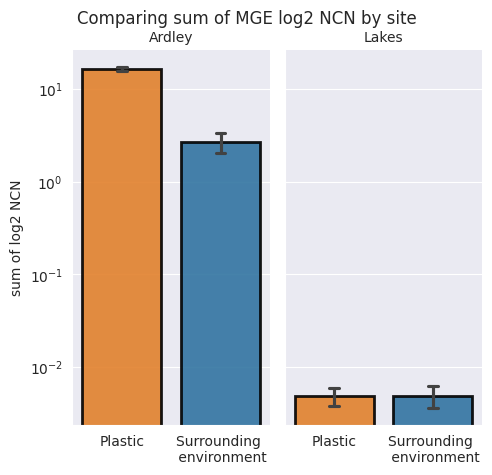

In [14]:
with sns.axes_style("darkgrid"):
    cat = sns.catplot(data = mge_general_sums, kind = "bar",
                      x="type_g", y="rel_ab", col = "ambient",
                      alpha = 0.9, hue_order = ["Surrounding \n environment", "Plastic"],
                      height=5, aspect=0.5,
                      errorbar = "se", capsize = 0.1, ecolor = "black", hue = "type_g",
                      fill = True,  edgecolor = "black", linewidth = 2 
                    )
    cat.fig.subplots_adjust(top=0.9)
    cat.fig.suptitle('Comparing sum of MGE log2 NCN by site')
    cat.set_xlabels("")
    cat.set_ylabels("sum of log2 NCN")
    plt.yscale("log")
    #cat.set_xticklabels(rotation=30)
    cat.set_titles("{col_name}")
plt.savefig("Site separated MGE log2 NCN - type_f.png", bbox_inches= "tight")

In [15]:
%matplotlib agg
os.chdir(all_dir)
os.chdir("target_results_general")
typeg_dir = os.getcwd()
os.chdir("../target_results_fine")
typef_dir = os.getcwd()
for antib in all_data["antib"].unique():
    print("##### Working on ", antib.upper(), " #####")
    antib_data = all_data.loc[all_data["antib"] == antib]
    for grouping in ["type_g", "type_f"]:
        print (grouping.upper())
        if grouping == "type_g":
            os.chdir(typeg_dir)
        else:
            os.chdir(typef_dir)
        sp_grouped = antib_data.groupby(["sample", "ambient", grouping]) 
        summed_samples = sp_grouped["rel_ab"].sum() 
        summed_samples = summed_samples.reset_index() 
        summed_samples["n_log2"] = np.log2(summed_samples["rel_ab"])

        for ambient in summed_samples["ambient"].unique():
            print("Working on ", ambient.upper())
            ambient_samples = summed_samples.loc[summed_samples["ambient"] == ambient]
            var_lst = [group["rel_ab"] for name, group in ambient_samples.groupby([grouping])] 
            nam_lst = [name for name, group in ambient_samples.groupby([grouping])] 
            var_lst_ln = [group["n_log2"] for name, group in ambient_samples.groupby([grouping])]
            fname = antib.upper() + "-" + ambient.upper() + "-" + grouping.upper() + "-arg_group_statistics.txt"
            with open(fname, "w") as file:
                print("Regular_values: ", stats.levene(*var_lst), file = file)
                try:
                    print("Regular_kruskal: ", stats.kruskal(*var_lst), file = file)
                    print("Log2_kruskal: ", stats.kruskal(*var_lst_ln), file = file)
                    print("Log2_values: ", stats.levene(*var_lst_ln), file = file)
                except:
                    print("Log2_values: ", stats.levene(*var_lst_ln), file = file)     
        post_lolo = sp.posthoc_conover(var_lst, p_adjust = "fdr_bh")
        post_lolo.rename(columns = {original_num:new_name for (original_num, new_name) in zip(post_lolo.columns, nam_lst)},
                         index = {original_num:new_name for (original_num, new_name) in zip(post_lolo.index, nam_lst)},
                         inplace = True)
        post_lolo = post_lolo[post_lolo < 0.05]
        fname = antib.upper() + "-" + ambient.upper() + "-" + grouping.upper() + "all_arg_comparisions.csv"
        post_lolo.to_csv(fname)

        fname = antib + "--adjusted NCN sums.png"
        plot_title = "Comparing the sum of all " + antib.upper() + " NCNs by site"
    
        with sns.axes_style("darkgrid"):
            cat = sns.catplot(data = summed_samples, kind="bar",
                              x=grouping, y="rel_ab", col="ambient",
                              height=6, aspect=0.5,
                              errorbar = "se", capsize = 0.1, ecolor = "black", hue = grouping,
                              fill = True,  edgecolor = "black", linewidth = 2
                             )
            cat.fig.subplots_adjust(top=0.9)
            cat.fig.suptitle(plot_title)
            cat.set_xlabels("")
            cat.set_ylabels("sum of all NCNs")
            plt.yscale("log")
            cat.set_titles("{col_name}")
            plt.savefig(fname, bbox_inches= "tight")

##### Working on  AMINOGLYCOSIDE  #####
TYPE_G
Working on  LAKES
Working on  ARDLEY
TYPE_F
Working on  LAKES
Working on  ARDLEY
##### Working on  AMPHENICOL  #####
TYPE_G
Working on  LAKES
Working on  ARDLEY
TYPE_F
Working on  LAKES
Working on  ARDLEY
##### Working on  VANCOMYCIN  #####
TYPE_G
Working on  LAKES
Working on  ARDLEY
TYPE_F
Working on  LAKES
Working on  ARDLEY
##### Working on  BETA LACTAM  #####
TYPE_G
Working on  LAKES
Working on  ARDLEY
TYPE_F
Working on  LAKES
Working on  ARDLEY
##### Working on  MDR  #####
TYPE_G
Working on  LAKES
Working on  ARDLEY
TYPE_F
Working on  LAKES
Working on  ARDLEY
##### Working on  TRIMETHOPRIM  #####
TYPE_G
Working on  LAKES
Working on  ARDLEY
TYPE_F
Working on  LAKES
Working on  ARDLEY
##### Working on  OTHER  #####
TYPE_G
Working on  LAKES
Working on  ARDLEY
TYPE_F
Working on  LAKES
Working on  ARDLEY
##### Working on  FLUOROQUINOLONE  #####
TYPE_G
Working on  LAKES
Working on  ARDLEY
TYPE_F
Working on  LAKES
Working on  ARDLEY
##### Wo